# Analyse des filières du cacao et du café dans les pays d'Afrique occidentale et centrale

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pandasai import SmartDataframe, SmartDatalake
from pandasai.llm import OpenAI
from pandasai.skills import skill
from pathlib import Path

# Chargement et nettoyage des données pour faciliter leur utilisation

Chargement des données sous forme de dataframes Pandas

In [7]:
os.chdir("/home/notebook-user/")
data_path = Path("data")
all_data_files = [path for path in data_path.glob("*.csv")]
dataframes = {df_name: pd.read_csv(data_file) for df_name, data_file in zip(["ie", "prod", "lu"], all_data_files)}

Suppression des colonnes redondantes, et transformation au format "catégorique" des colonnes pertinentes

In [8]:
drop_cols = ["Domain Code", "Domain", "Area Code (M49)", "Element Code", "Item Code", "Item Code (CPC)", "Year Code", "Flag"]
cat_cols = ["Area", "Element", "Item", "Unit", "Flag Description", "Note"]

for df_name in dataframes.keys():
    dataframes[df_name] = dataframes[df_name].drop(drop_cols, axis=1, errors="ignore")
    dataframes[df_name][cat_cols] = dataframes[df_name][cat_cols].astype("category")

# Pour la manipulation directe des dataframes dans le cadre d'opérations simples
df_ie = dataframes["ie"]
df_prod = dataframes["prod"]
df_lu = dataframes["lu"]

# Exploration et synthèse des données

## Analyse des imports/exports

Nous commençons par comparer les recettes générées par l'exportation des différents produits renseignés au cours des 5 dernières années :

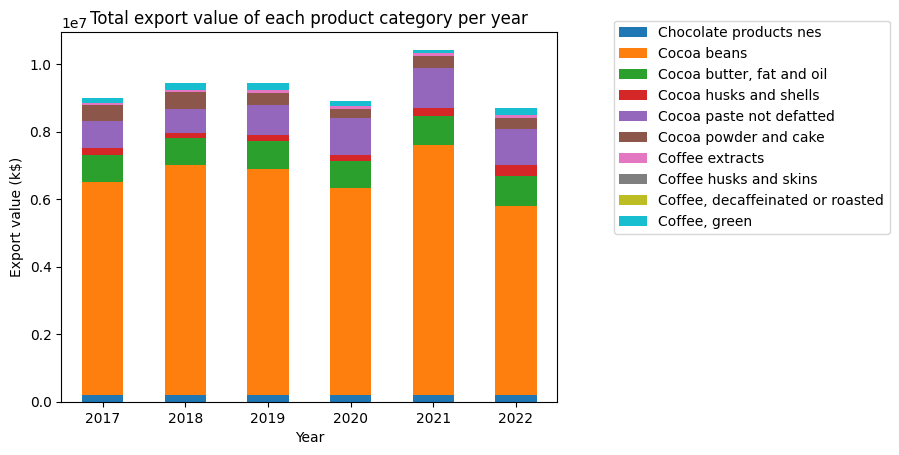

In [9]:
gp = df_ie[(df_ie['Element'] == 'Export Value') & (df_ie['Unit'] == '1000 USD') & (df_ie['Year'] >= 2017)].groupby(["Item", "Year"])
pivot = gp.sum("Value").reset_index().pivot(index="Year", columns="Item")
pivot.columns = pivot.columns.droplevel(0)
ax = pivot.plot.bar(stacked=True, title="Total export value of each product category per year", rot=0)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel("Export value (k$)")
plt.show()

Nous voyons que la grande majorité des recettes provient de l'export de fèves de cacao. La pâte de cacao non dégraissée et les graisses dérivées du cacao génèrent aussi une part non négligeable de recettes.

Nous nous intéressons maintenant aux imports de ces mêmes produits par les pays africains concernés, sur les 5 dernières années :

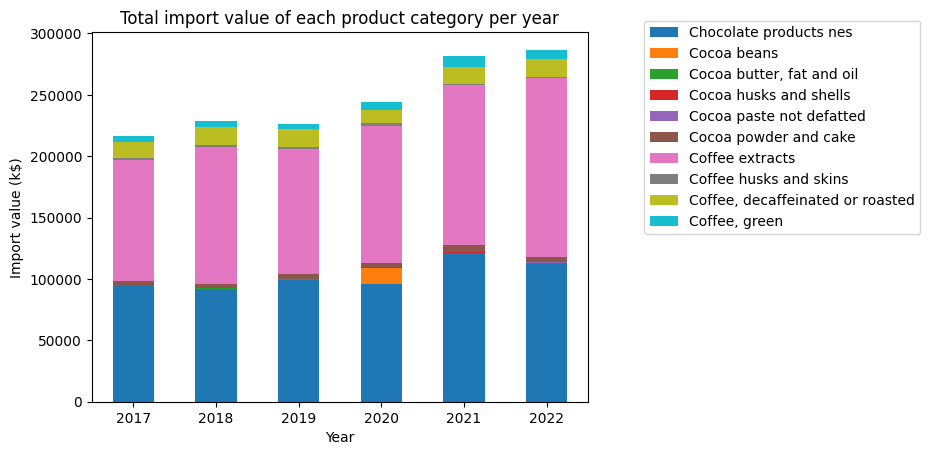

In [10]:
gp = df_ie[(df_ie['Element'] == 'Import Value') & (df_ie['Unit'] == '1000 USD') & (df_ie['Year'] >= 2017)].groupby(["Item", "Year"])
pivot = gp.sum("Value").reset_index().pivot(index="Year", columns="Item")
pivot.columns = pivot.columns.droplevel(0)
ax = pivot.plot.bar(stacked=True, title="Total import value of each product category per year", rot=0)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel("Import value (k$)")
plt.show()

- Premièrement, nous constatons que les montants des recettes générées par l'exportation de ces produits sont supérieurs à ceux dépensés pour l'importation (d'un facteur 3 environ). Les pays concernés sont avant tout producteurs plutôt que consommateurs
- Deuxièmement, nous constatons que la majorité des imports concerne des produits transformés destinés à la consommation : extraits de café et produits de consommation à base de chocolat constituent le gros de cette importation. Les pays africains produisent les matières premières (notamment pour la filière chocolat) mais ne les transforment pas eux-mêmes pour les valoriser.

Nous nous intéressons maintenant à l'évolution de l'exportation sur les 60 dernières années pour les produits générant le plus de recettes aujourd'hui (en l'occurrence, la filière cacao) :

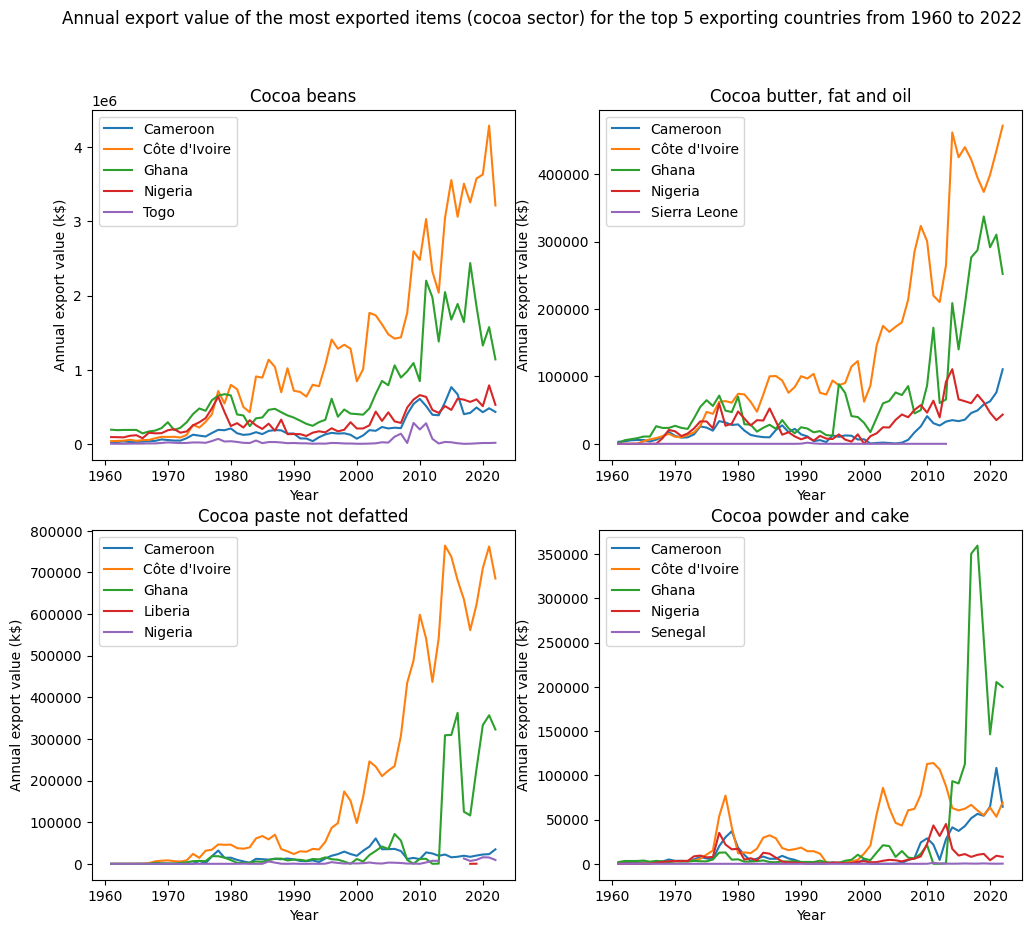

In [11]:
plot_items = ["Cocoa beans", "Cocoa butter, fat and oil", "Cocoa paste not defatted", "Cocoa powder and cake"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for item, ax in zip(plot_items, axes.flatten()):
    
    exp_gpArea = df_ie[(df_ie.Element == "Export Value") & (df_ie.Item == item)].groupby("Area")
    top_5_exp = exp_gpArea["Value"].sum().nlargest(5).index

    exp_top5_gpArea = df_ie[(df_ie.Element == "Export Value") & (df_ie.Item == item) & df_ie.Area.isin(top_5_exp)][["Area", "Value", "Year"]].groupby("Area", observed=True)

    for area, data in exp_top5_gpArea:
        data.plot(x="Year", y="Value", label=area, ax=ax)
    ax.set_ylabel("Annual export value (k$)")
    ax.set_title(item)

fig.suptitle("Annual export value of the most exported items (cocoa sector) for the top 5 exporting countries from 1960 to 2022")
plt.show()

Nous observons que les deux principaux pays exporteurs sont la Côte d'Ivoire et le Ghana. Le Cameroon et le Nigeria semblent également émerger sur le marché depuis la dernière décennie. Malgré des variations annuelles conséquentes, les recettes sont globalement en hausse régulière depuis les années 70, indiquant un marché toujours en croissance sur le long terme.

Nous jetons tout de même un œil aux produits issus de la filière café et regardons l'évolution des exports pour les plus gros pays exporteurs :

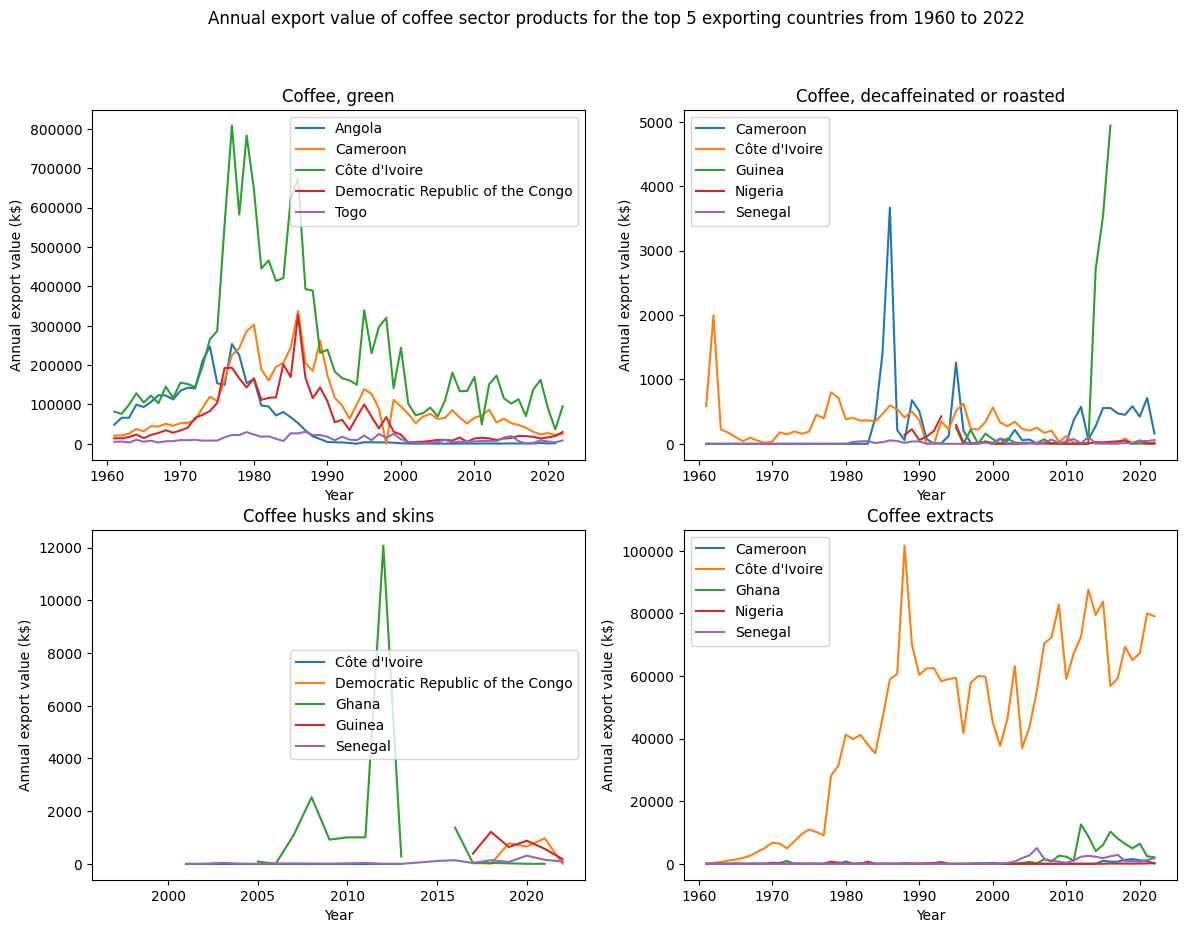

In [12]:
plot_items = ["Coffee, green", "Coffee, decaffeinated or roasted", "Coffee husks and skins", "Coffee extracts"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for item, ax in zip(plot_items, axes.flatten()):
    
    exp_gpArea = df_ie[(df_ie.Element == "Export Value") & (df_ie.Item == item)].groupby("Area")
    top_5_exp = exp_gpArea["Value"].sum().nlargest(5).index

    exp_top5_gpArea = df_ie[(df_ie.Element == "Export Value") & (df_ie.Item == item) & df_ie.Area.isin(top_5_exp)][["Area", "Value", "Year"]].groupby("Area", observed=True)

    for area, data in exp_top5_gpArea:
        data.plot(x="Year", y="Value", label=area, ax=ax)
    # ax.legend(bbox_to_anchor=(0.05, 0.95))
    ax.set_ylabel("Annual export value (k$)")
    ax.set_title(item)

fig.suptitle("Annual export value of coffee sector products for the top 5 exporting countries from 1960 to 2022")
plt.show()

Malgré des données plus disparates et des revenus plus faibles, nous pouvons noter deux faits intéressants :
- la filière du café vert a connu un pic dans les années 80, où les recettes de l'export étaient comparables à celui du cacao, avant de chuter et se stabiliser autour des 100M\$ depuis les années 2000 (les raisons sont évoquées [ici](https://www.rfi.fr/fr/emission/20111226-renaissance-cafe-africain))
- la filière des extraits de café en Côte d'Ivoire (seul acteur de poids sur cette filière dans nos données) n'a pas connu la chute des années 90 et conserve des niveaux d'exports relativement stables (autour des 80M\$)

**Il est à noter que cette analyse ne couvre que les pays inclus dans les données, qui excluent notamment l'Afrique orientale. Certains des plus gros pays producteurs de café africains ne sont donc pas inclus, tels que l'Éthiopie et l'Ouganda.**

## Analyse de la production

Nous nous intéressons maintenant aux données de production. Ces dernières concernent les produits de culture bruts que sont les fèves de cacao et de café.

Nous comparons l'évolution des quantités produites et des surfaces agraires dédiées au cours des cinq dernières années :

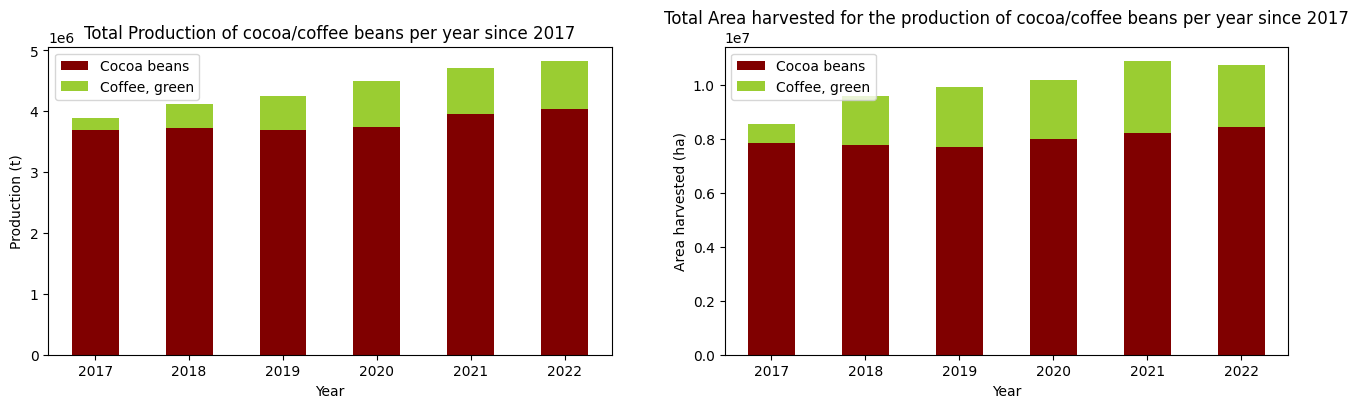

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
elements, titles, ylegends = ["Production", "Area harvested"], ["Production", "Area harvested for the production"], ["Production (t)", "Area harvested (ha)"]
cc_colors = ["maroon", "yellowgreen"]

for element, title, ylegend, ax in zip(elements, titles, ylegends, axes):
    gp = df_prod[(df_prod['Element'] == element) & (df_prod['Year'] >= 2017)].groupby(["Item", "Year"])
    pivot = gp.sum("Value").reset_index().pivot(index="Year", columns="Item")
    pivot.columns = pivot.columns.droplevel(0)
    pivot.columns.name = None
    pivot.plot.bar(stacked=True, title=f"Total {title} of cocoa/coffee beans per year since 2017", ax=ax, color=cc_colors, rot=0)
    # ax.legend(bbox_to_anchor=(1.1, 1.05))
    ax.set_ylabel(ylegend)
plt.show()

Nous observons, en corrélation avec les chiffres d'exportation, que la majorité de la production concerne la filière cacao. Nous constatons cependant une hausse régulière de la production de café, tandis que celle du cacao semble relativement stagnante. Le développement à court terme de la filière café paraît donc plus dynamique (une tendance soulignée pour la Côte d'Ivoire dans cet [article](https://www.agenceecofin.com/cafe/0202-105100-cote-d-ivoire-la-production-de-cafe-a-quasiment-double-a-92-300-tonnes-entre-janvier-et-septembre-2022)).

Nous pouvons affiner notre vision de la production de ces produits en analysant les taux de rendements annuels :

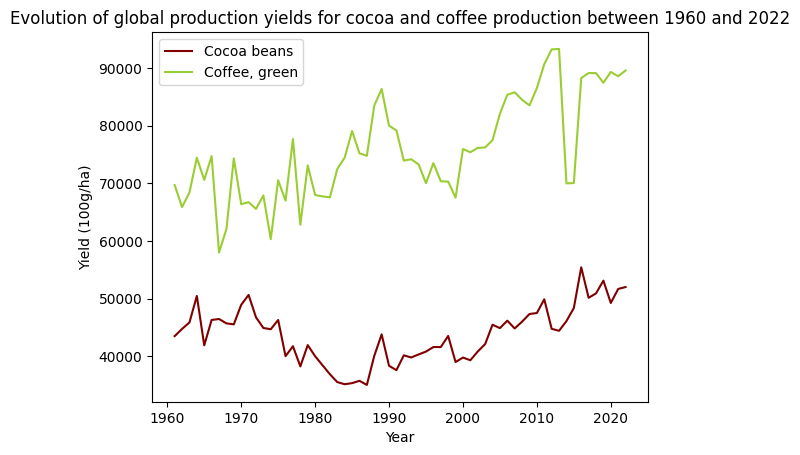

In [14]:
fig, ax = plt.subplots()

for item, color in zip(df_prod.Item.unique(), cc_colors):
    annual_yield_item = df_prod[(df_prod.Element == "Yield") & (df_prod.Item == item)].groupby("Year").sum("Value").reset_index()
    annual_yield_item.plot(x="Year", y="Value", label=item, ax=ax, c=color)

ax.set_ylabel("Yield (100g/ha)")
ax.set_title("Evolution of global production yields for cocoa and coffee production between 1960 and 2022")
plt.show()

Deux points d'intérêt apparaissent :
- Les taux de rendement sont en globale augmentation depuis les années 60. Ceci indique une valorisation croissante des terres cultivées et donc une capacité à améliorer la production pour une surface cultivable donnée.
- La culture du café présente une rendement quasiment deux fois plus élevé que celle du cacao, pour la même surface cultivée. Il y a donc un fort intérêt à développer cette culture qui permet *a priori* une exploitation plus rentable des terres (de multiples autres facteurs rentrent en jeu tels que la valeur du produit sur les marchés, et les nombreux autres coûts de production spécifiques à la culture : eau, ressources, matériel, main-d'œuvre...)

## Analyse de l'exploitation des terres agricoles

Nous nous intéressons à l'usage des terres agricoles et la répartition des activités

Nous synthétisons les diverses données mises à disposition dans la dernière table :

In [15]:
contents_table_lu = df_lu[["Element", "Item", "Unit"]].value_counts().reset_index().rename({0: "n_rows"}, axis=1).sort_values(["Element", "Item", "Unit"])
contents_table_lu.index = range(len(contents_table_lu))
contents_table_lu

,Element,Item,Unit,n_rows
0,Area,Agricultural land,1000 ha,1586
1,Area,Agriculture,1000 ha,1586
2,Area,Arable land,1000 ha,1586
3,Area,Country area,1000 ha,1586
4,Area,Cropland,1000 ha,1586
5,Area,Land area,1000 ha,1586
6,Area,Perm. meadows & pastures - Nat. growing,1000 ha,21
7,Area,Permanent crops,1000 ha,1525
8,Area,Permanent meadows and pastures,1000 ha,1586
9,Area,Temporary crops,1000 ha,546


Nous comparons le partage des terres agricoles entre les différents secteurs d'activité au cours des 60 dernières années :

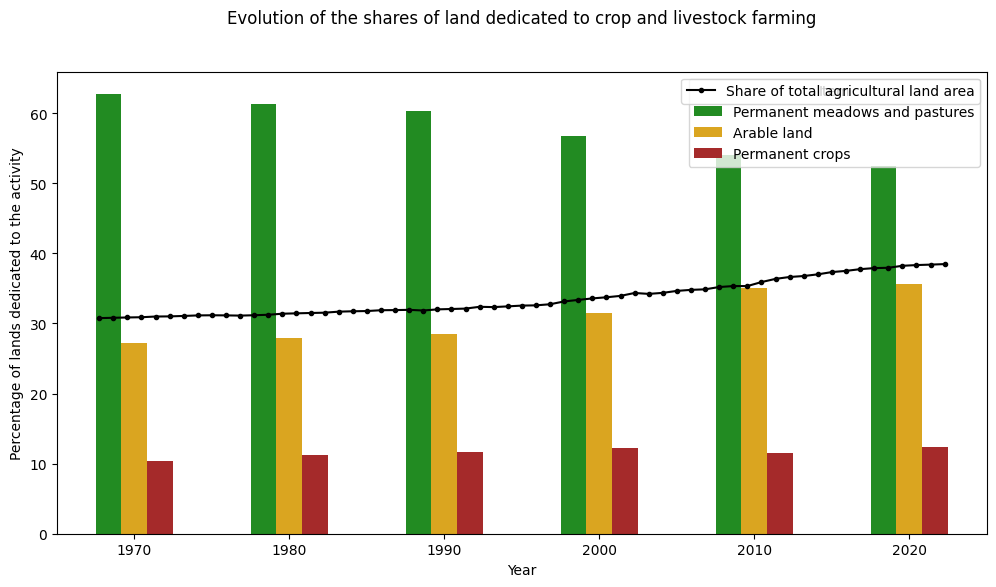

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

df_gp = df_lu[(df_lu.Element == "Share in Agricultural land") & df_lu.Item.isin(["Permanent meadows and pastures", "Arable land", "Permanent crops"]) & (df_lu.Year % 10 == 0)].copy()
df_gp.Item = pd.Categorical(df_gp.Item, categories=["Permanent meadows and pastures", "Arable land", "Permanent crops"], ordered=True)
gp = df_gp.groupby(["Year", "Item"], observed=True)
pivot = gp.mean("Value").reset_index().pivot(index="Year", columns="Item")
pivot.columns = pivot.columns.droplevel(0)
pivot.plot.bar(ax=ax, color=["forestgreen", "goldenrod", "brown"], rot=0)
ax.set_ylabel("Percentage of lands dedicated to the activity")
ax.set_title("Evolution of the shares of land dedicated to crop and livestock farming")

ax2 = ax.twiny()  # Necessary to plot line (x-range=[1960;2022]) and bar chart (x-range=[0-5]) on different x-axes, in order to be able to display them together
ax2.set_axis_off()
df_lu[(df_lu.Element == "Share in Land area") & (df_lu.Item == "Agricultural land")].groupby("Year").mean("Value").reset_index().plot(x="Year", y="Value", ax=ax2, style=".-",
                                                                                                                              label="Share of total agricultural land area", c="black")
plt.show()

Nous constatons une diminution régulière des surfaces de prairies et pâturages, au profit de terres arables. La surface des terres dédiées aux cultures permanentes (qui incluent le cacao et le café) n'a que peu évolué. Notons également que le pourcentage de terres agricoles lui-même est en globale augmentation.

## Étude des sources de données

Nous commençons par regarder la répartition des sources telles que renseignées dans la colonne "Flag Description" pour l'ensemble des jeux de données :

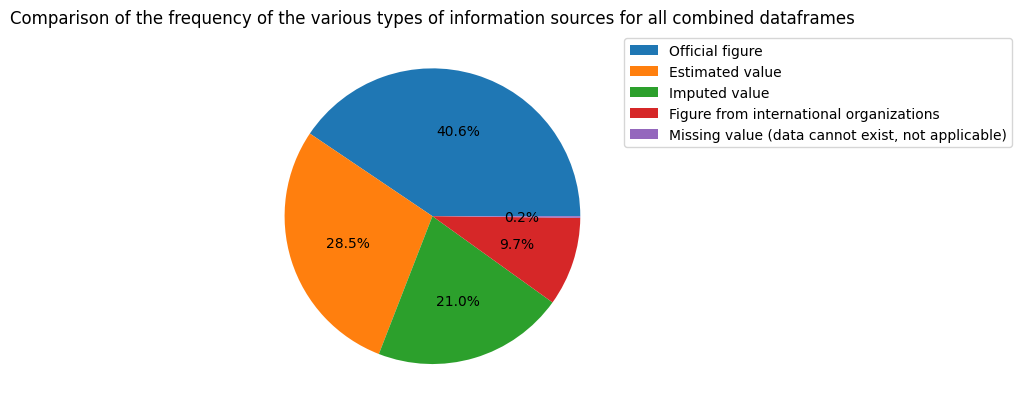

In [17]:
fig, ax = plt.subplots()
all_flags = pd.concat((df_ie["Flag Description"], df_prod["Flag Description"], df_lu["Flag Description"])).value_counts()
all_flags.plot.pie(ax=ax, autopct='%1.1f%%', legend=True, ylabel="", labeldistance=None)
ax.set_title("Comparison of the frequency of the various types of information sources for all combined dataframes")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Nous observons notamment que presque 50% des entrées sont marquées comme provenant d'estimations ou d'interpolations/extrapolations. Selon les méthodes employées pour générer ces valeurs, elles peuvent être considérées comme acceptables ou indésirables. Sans avoir plus d'informations sur la façon dont ces valeurs sont calculées, il serait préférable de recommencer l'analyse sans les inclure. Dans notre cas, celà diminue d'un facteur 2 la quantité de données disponibles.

Nous nous penchons maintenant sur une visualisation plus détaillée de la répartition des sources de données. Nous séparons les données issue de chaque jeu, et nous regardons ces répartitions pour chaque tranche de 10 ans (2 ans seulement pour la dernière tranche) :

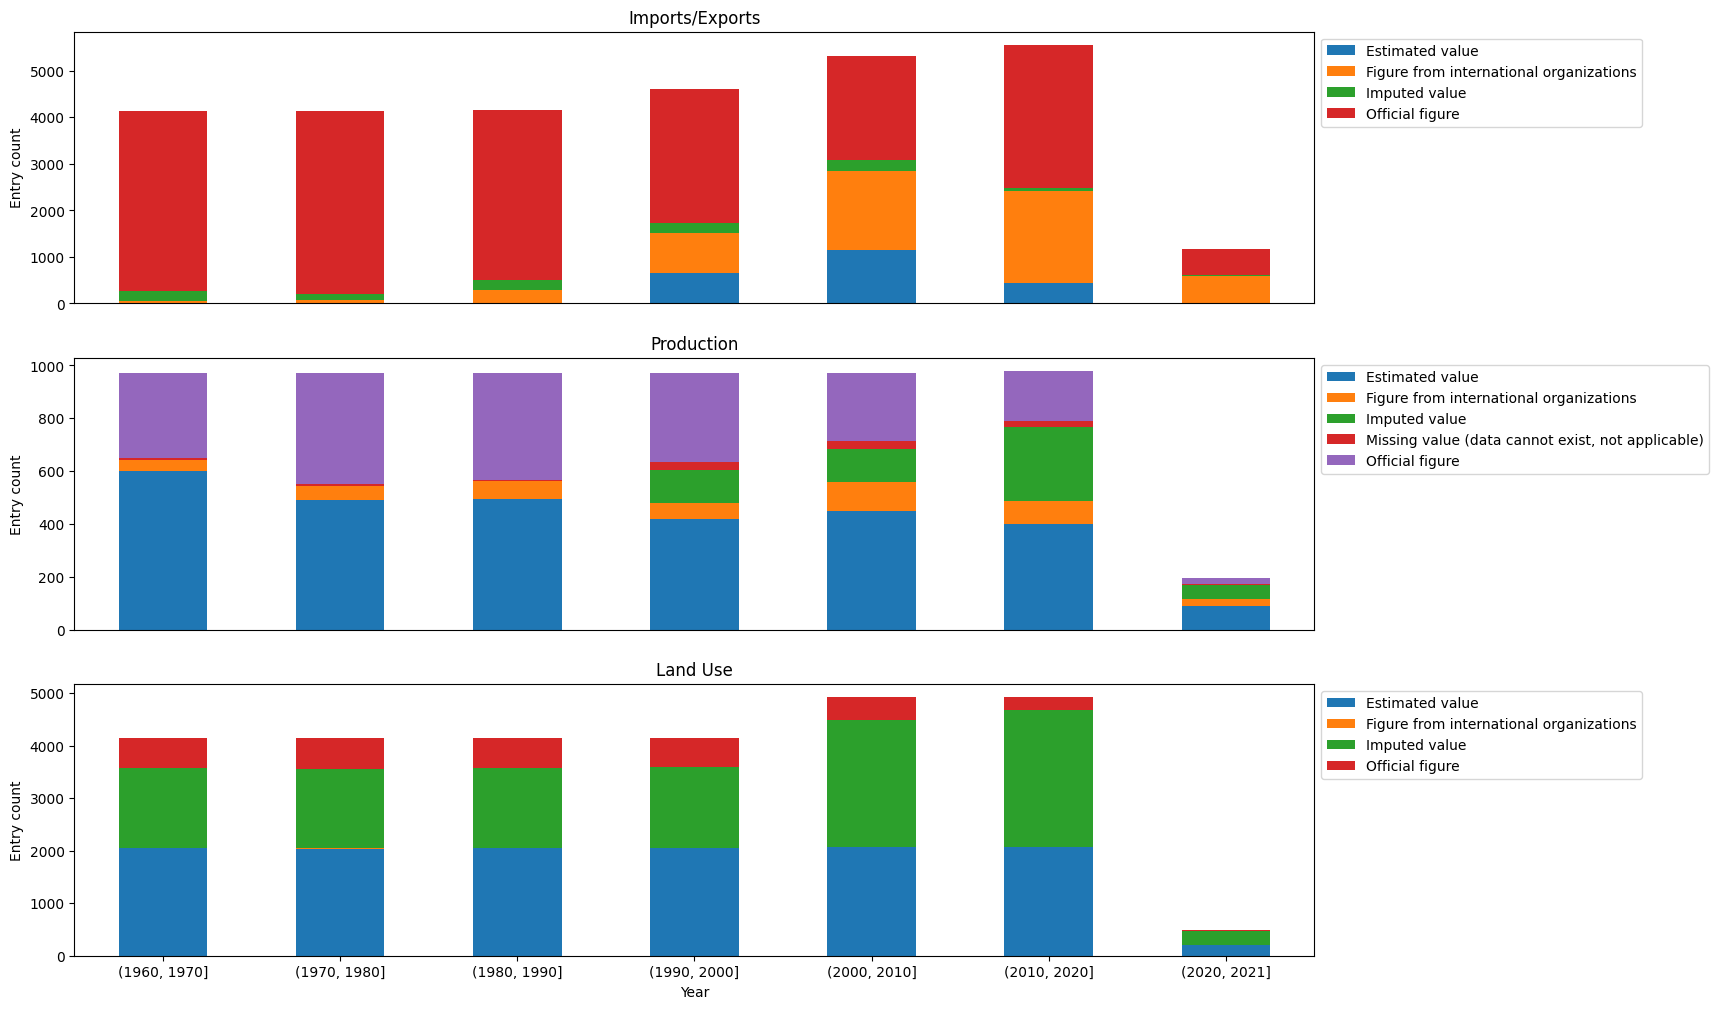

In [18]:
dfs = [df_ie, df_prod, df_lu]
titles = ["Imports/Exports", "Production", "Land Use"]
fig, axes = plt.subplots(len(dfs), 1, figsize=(16, 12))

for n_plot, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
    pivot = df.groupby(["Year", "Flag Description"]).Value.count().reset_index().pivot(index="Year", columns="Flag Description")
    pivot.columns = pivot.columns.droplevel(0)
    pivot.columns.name = None
    pivot = pivot.reset_index()

    # Resample data over 10-year intervals
    max_year = pivot.Year.max()
    pivot.Year = pd.cut(pivot.Year, np.arange(pivot.Year.min() - 1, max_year, 10))
    incomplete_interval = pd.Interval(pivot.Year.max().right, max_year, closed='right')
    pivot.Year = pivot.Year.cat.add_categories(incomplete_interval).fillna(incomplete_interval)

    pivot_resampled = pivot.copy()
    pivot_resampled = pivot_resampled.groupby("Year").sum()
    pivot_resampled.plot.bar(stacked=True, ax=ax, rot=0)

    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel("Entry count")
    ax.set_title(title)

    if n_plot != len(dfs) - 1:
        ax.get_xaxis().set_visible(False)

plt.show()

Nous observons principalement que seul le tableau détaillant les données d'imoprts/exports repose en grande majorité sur des sources officielles et organisations internationales. Nous constatons d'ailleurs que la part de données issues de ces dernières est de plus en plus importante au fil du temps.

Au contraire, les données concernant la production et l'utilisation des terres sont issues en majorité d'estimations et d'extrapolations. On note en particulier une diminution au fil du temps de la part de données de production issues de sources officielles. Les données sur l'utilisation des terres sont quant à elles issues en vaste majorité d'estimations diverses.

Un client soucieux de la véracité des données fournies préférera peut-être se coontenter d'une analyse des données d'import/export.

## Conversation avec les données : utilisation d'un LLM avec PandasAI

### AVERTISSEMENT : l'utilisation d'un tel outil implique l'envoi des données à analyser sur un serveur hébergeant le modèle utilisé. Cette action peut être en conflit avec des politiques de gouvernance des données requises par la compagnie, le client, ou les autorités juridiques du pays. Avant l'envoi de toute donnée, il est nécessaire de s'assurer qu'une telle action n'enfreint aucune règlementation ou loi.

Dans le cadre de cet exercice, nous faisons l'hypothèse que les données utilisées sont publiques et peuvent être diffusées sans contrainte.

### PRÉCAUTIONS D'EMPLOI POUR L'UTILISATION DE LLMS POUR LA BUSINESS INTELLIGENCE :
Les LLMs sont par nature sujets à l'erreur, et variables dans leurs outputs. Quelques considérations et précautions d'usage doivent être gardées à l'esprit lorsqu'on utilise l'outil PandasAI :
- Ne pas croire les résultats du modèle sur parole. Une bonne précaution est de lui demander de retourner le code généré et exécuté afin de produire ce résultat, pour contrôler une éventuelle erreur de raisonnement. Le code peut aussi être récupéré et amélioré par l'utilisateur.
- La répétabilité de l'output du code pour une même requête peut être améliorée en jouant sur certain paramètres, tels que la "température" du LLM, et en fixant les "seeds" lorsque cela est possible. Il est à noter que cela peut affecter la capacité du modèle à être créatif dans ses réponses.

Voici comment nous pouvons instancier des dataframes/datalakes intelligents à partir de nos données :

- Chargement du LLM (requiert un API token, chez OpenAI par exemple, obtenable [ici](https://platform.openai.com/account/api-keys))
- Création de SmartDataframes utilisés pour interroger individuellement chaque dataframe
- Création d'un SmartDalake utilisés pour des requêtes requérant la combinaison de multiples dataframes

In [337]:
with open("openai_api_key.txt", "r") as f:
    api_token = f.readline().replace("\n", "")
llm = OpenAI(api_token=api_token)

sdf_ie = SmartDataframe(dataframes["ie"], config={"llm": llm, "save_charts": True, "save_charts_path": "exports/charts/"})
sdf_prod = SmartDataframe(dataframes["ie"], config={"llm": llm, "save_charts": True, "save_charts_path": "exports/charts/"})
sdf_lu = SmartDataframe(dataframes["ie"], config={"llm": llm, "save_charts": True, "save_charts_path": "exports/charts/"})
sdl = SmartDatalake(list(dataframes.values()), config={"llm": llm, "save_charts": True, "save_charts_path": "exports/charts/"})

Démonstration d'un exercice de synthèse relativement complexe sur le jeu des imports/exports à l'aide du SmartDataFrame correspondant :

In [342]:
print(sdf_ie.chat("What are the top 5 areas in terms of cocoa beans export value since 2017 ? Give the name of the area and the corresponding total export value since 2017"), "\n")
print(sdf_ie.last_code_executed)

                               Area       Value
0                     Côte d'Ivoire  21461002.0
1                             Ghana   9972835.0
2                           Nigeria   3598627.0
3                          Cameroon   2660714.0
4  Democratic Republic of the Congo    426568.0 

top_export_areas = dfs[0][(dfs[0]['Element'] == 'Export Value') & (dfs[0]['Item'] == 'Cocoa beans') & (dfs[0]['Year'] >= 2017)].groupby('Area')['Value'].sum().nlargest(5)
result = {'type': 'dataframe', 'value': top_export_areas.reset_index()}


Démonstration des capacités du modèle à générer des graphiques :

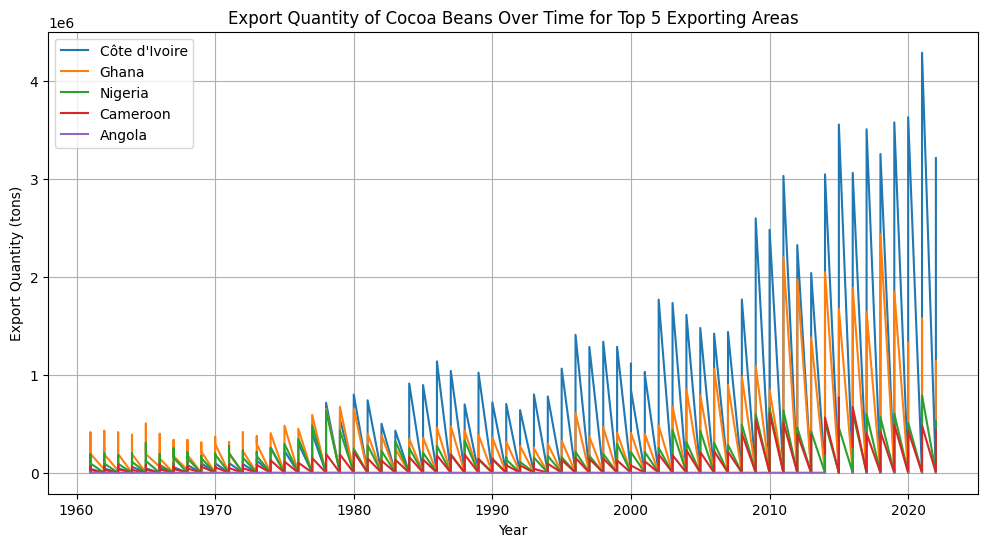

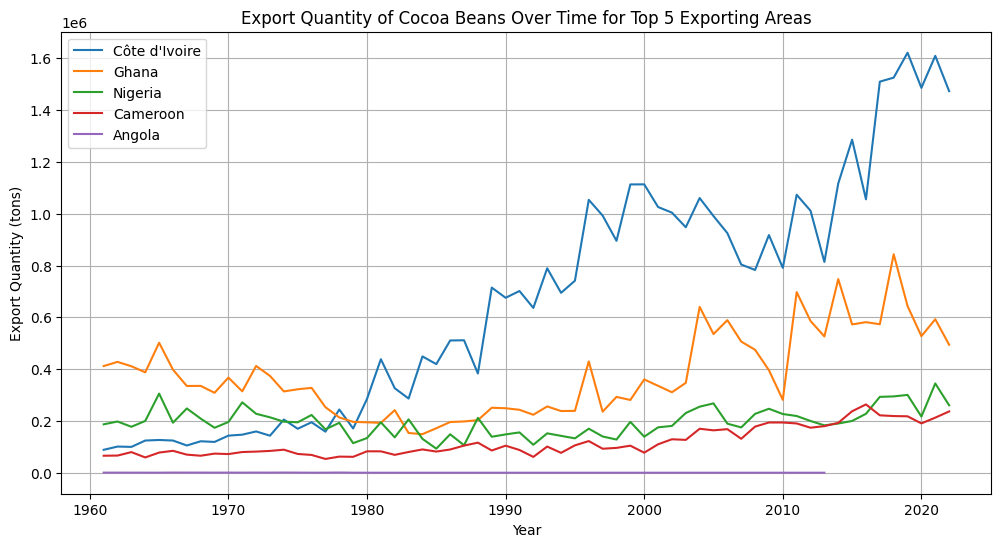

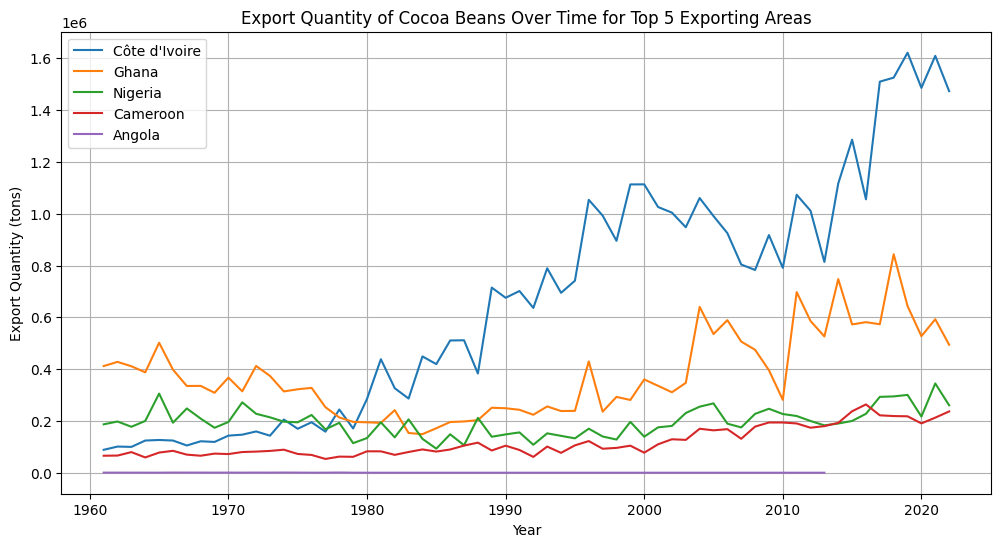

Unfortunately, I was not able to answer your question, because of the following error:

[Errno 2] No such file or directory: 'exports/charts/45b25896-750f-4586-a7b7-a57fa12de84d.png'
 

top_exporting_areas = dfs[0].loc[dfs[0]['Element'] == 'Export Quantity'].groupby('Area')['Value'].sum().nlargest(5).index.tolist()
filtered_data = dfs[0][dfs[0]['Area'].isin(top_exporting_areas) & (dfs[0]['Item'] == 'Cocoa beans')]
plt.figure(figsize=(12, 6))
for area in top_exporting_areas:
    area_data = filtered_data[(filtered_data['Area'] == area) & (filtered_data['Element'] == 'Export Quantity')]
    plt.plot(area_data['Year'], area_data['Value'], label=area)
plt.xlabel('Year')
plt.ylabel('Export Quantity (tons)')
plt.title('Export Quantity of Cocoa Beans Over Time for Top 5 Exporting Areas')
plt.legend()
plt.grid(True)
plt.show()
result = {'type': 'plot', 'value': 'exports/charts/45b25896-750f-4586-a7b7-a57fa12de84d.png'}


In [343]:
print(sdf_ie.chat("Plot the export quantity (in tons) of cocoa beans over time for the top 5 cocoa beans exporting areas"), "\n")
print(sdf_ie.last_code_executed)

Démonstration de l'utilisation du SmartDalake pour un graphique nécessitant l'utilisation de plusieurs jeux de données :

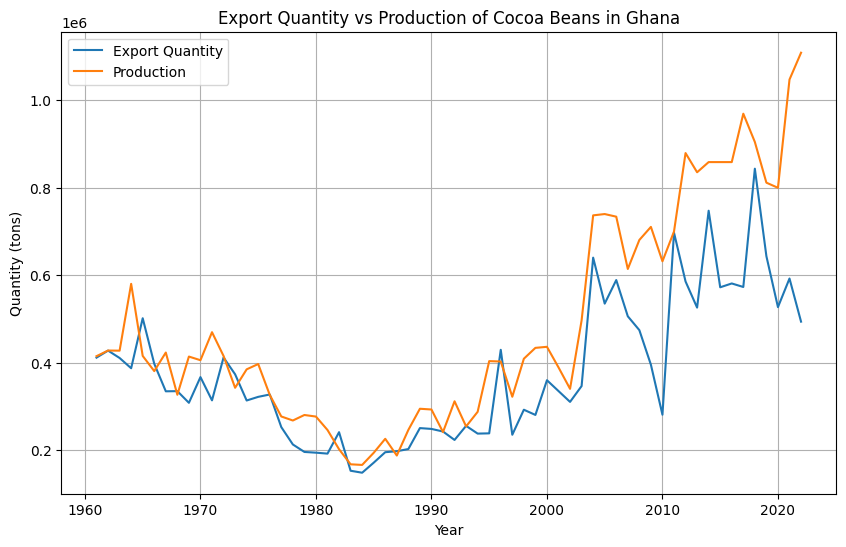

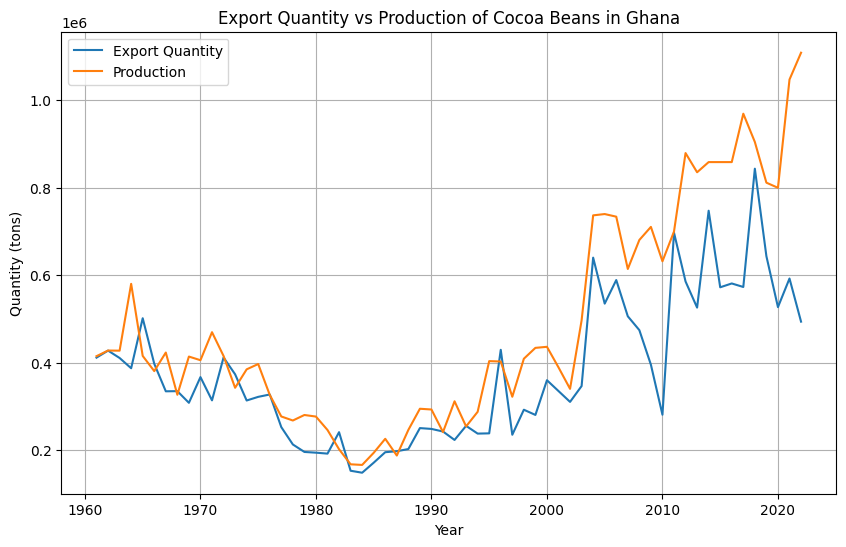

exports/charts/54e6147b-564b-4492-963d-6f4021e586ec.png 

ghana_export = dfs[0][(dfs[0]['Area'] == 'Ghana') & (dfs[0]['Element'] == 'Export Quantity') & (dfs[0]['Item'] == 'Cocoa beans')]
ghana_production = dfs[1][(dfs[1]['Area'] == 'Ghana') & (dfs[1]['Element'] == 'Production') & (dfs[1]['Item'] == 'Cocoa beans')]
plt.figure(figsize=(10, 6))
plt.plot(ghana_export['Year'], ghana_export['Value'], label='Export Quantity')
plt.plot(ghana_production['Year'], ghana_production['Value'], label='Production')
plt.xlabel('Year')
plt.ylabel('Quantity (tons)')
plt.title('Export Quantity vs Production of Cocoa Beans in Ghana')
plt.legend()
plt.grid(True)
plt.savefig('exports/charts/54e6147b-564b-4492-963d-6f4021e586ec.png')
plt.show()
result = {'type': 'plot', 'value': 'exports/charts/54e6147b-564b-4492-963d-6f4021e586ec.png'}


In [355]:
print(sdl.chat("Plot the 'export quantity' and the 'production' of cocoa beans from Ghana"), "\n")
print(sdl.last_code_executed)

Notre impression est que ce genre d'outil, bien que très prometteur, manque encore de maturité. La fiabilité des résultats chute rapidement avec la complexité des requêtes adressées au modèle. On perd généralement plus de temps à vérifier et corriger les outputs du modèle qu'on en aurait passé à faire l'analyse soi-même. Ils peuvent cependant servir d'assistants de code pour résoudre un problème que l'on a en tête et que l'on ne sait pas trop comment formuler. Nous continuerons à monitorer les progrès de ces outils et des LLMs sous-jacents, ces derniers connaissant une évolution fulgurante.

# Réflexion sur l'estimation des taux de rendements dans un futur proche pour la production de cacao et café

La prédiction des taux de production nous semble être un problème très complexe, particulièrement sur le court terme :

- Comme vu sur le graphe d'évolution historique des taux de rendements, même si une tendance générale de croissance semble se dessiner sur le long terme, de fortes fluctuations peuvent se produire d'une année sur l'autre
- Les facteurs influençant sur ces fluctuations sont nombreux et difficiles à rassembler sous forme de données structurées
- L'un des facteurs les plus influents, qui est la météo, reste très difficile à prédire, et n'est pas considéré dans les données fournies
- D'autres facteurs importants comme l'avancement des techologies et pratiques agricoles, ou les financements alloués au développement des cultures, sont difficiles à relever et représenter sous formes de données quantifiées
- Enfin, nous avons vu que les données de production disponibles dans cet exercice étaient issues majoritairement d'estimations dont les méthodes de calcul nous sont inconnues

Une prédiction de tendance d'évolution à long terme (en dizaine d'années) serait peut-être réalisable en utilisant les données de météorologie issues de modèles climatiques, combinées à des données sur les moyens technologiques et financiers à disposition des cultivateurs. À court terme, nosu pensons qu'il y a trop de fluctuations pour pouvoir réaliser des prédictions qui aient une chance d'être plus pertinentes qu'une simple extrapolation linéaire.


# Réflexion sur l'investissement produit brut vs. transformé dans la filière cacao

Comme nous avons vu précédemment, les pays d'Afrique Occidentale sont avant tout producteurs de fèves de cacao. Ils ne produisent que peu de produits chocolatés directement destinés à la consommation. La transformation de la fève de cacao en produits chocolatés génère une plus-value à la revente dont ces pays producteurs ne profitent donc que très peu.

Des règlementations peuvent être mises en place pour favoriser le développement de la filière des produits transformés dans les pays producteurs de cacao, telle que la surtaxe des exports pour la fève brute.

Les défis à relever pour la création et le succès d'une filière de transformation du cacao dans les pays d'Afrique sont nombreux. Cela requiert d'investir afin de construire les infrastructures nécessaires sur place, former la main-d'oeuvre, adapter la logistique, réussir à se placer sur les marchés... En outre, on passe de la production/vente d'un produit unique destiné à des clients industriels, vers une multitude de produits divers destinés aux consommateurs.

Sur le long terme, en considérant une surtaxe de 30% sur la valeur exportée de la fève brute VS. 2% pour les produits transformés, la création d'une filière locale de transformation finirait par être rentable.

Si le client ne possède pas déjà une telle filière dans un autre pays, la mise en place sera sans doute beaucoup plus difficile, et l'investissement plus lourd. L'enjeu sera alors de récupérer la plus-value faite sur les produits transformés par rapport à la fève brute seule, en plus de bénéficier d'une taxation plus légère.

En disposant d'une estimation du coût nécessaire à la création d'une chaîne de transformation du cacao destinées au traitement de la production des exploitations du client, il serait possible de déterminer le temps nécessaire pour amortir l'investissement de départ grâce au gain hypothétique acquis par la plus-value des produits transformés et leur taxation plus favorable.